In [1]:
# Import all relevant packages
import tensorflow as tf
from tensorflow.python.client import device_lib
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.gridspec as gridspec

In [2]:
# --- File and Folder Setup ---
extract_folder = "trainedWRc_resNet18_focalLoss"
image_filename = "test_sample_image.png" # Local path for the test image

In [3]:
import trainedWRc_resNet18_focalLoss
model = trainedWRc_resNet18_focalLoss.load_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data_unnormalized             │ (None, 224, 224, 3)       │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ data_ (Normalization)         │ (None, 224, 224, 3)       │         301,057 │ data_unnormalized[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ data_[0][0]                │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_ (Conv2D)               │ (None, 112, 112, 64)      │           9,472 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_conv1_                     │ (None, 112, 112, 64)      │             256 │ conv1_[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 112, 112, 64)      │               0 │ bn_conv1_[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ re_lu[0][0]                │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 58, 58, 64)        │               0 │ max_pooling2d[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2a_ (Conv2D)      │ (None, 56, 56, 64)        │          36,928 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2a_                │ (None, 56, 56, 64)        │             256 │ res2a_branch2a_[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 56, 56, 64)        │               0 │ bn2a_branch2a_[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_3              │ (None, 58, 58, 64)        │               0 │ re_lu_1[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2b_ (Conv2D)      │ (None, 56, 56, 64)        │          36,92

 Total params: 11,498,638 (43.86 MB)

 Trainable params: 11,187,981 (42.68 MB)

 Non-trainable params: 310,657 (1.19 MB)

In [4]:
# Load the original image without resizing for display
original_img = Image.open(image_filename)
true_class_name = 'Deposit' # <--- SET YOUR TRUE CLASS HERE, e.g., 'Broken'

In [5]:
# Dynamically extract image_size from the model's input shape
image_size = (model.input_shape[1], model.input_shape[2])

# Calculate new dimensions to fit within image_size while preserving aspect ratio
original_width, original_height = original_img.size
target_width, target_height = image_size

# Determine scaling factor
scale = min(target_width / original_width, target_height / original_height)
new_width = int(original_width * scale)
new_height = int(original_height * scale)

# Resize the image
# Image.LANCZOS is a high-quality resampling filter for shrinking.
resized_img = original_img.resize((new_width, new_height), Image.LANCZOS)

# Create a new black image (canvas) of target_size
padded_img = Image.new("RGB", image_size, (0, 0, 0))

# Calculate paste position to center the resized image
paste_x = (target_width - new_width) // 2
paste_y = (target_height - new_height) // 2

# Paste the resized image onto the black canvas
padded_img.paste(resized_img, (paste_x, paste_y))

# Assign the padded image to 'img' for consistency with previous code
img = padded_img

# Convert the padded PIL image to a numpy array
# By default, image.img_to_array converts to float32 with values in [0, 255]
img_array = image.img_to_array(img)
# Expand dimensions to create a batch of 1 image (required for model.predict)
img_array = np.expand_dims(img_array, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step

--- Prediction Result ---
Predicted class index: 5
Predicted class name: Deposit
True class name: Deposit


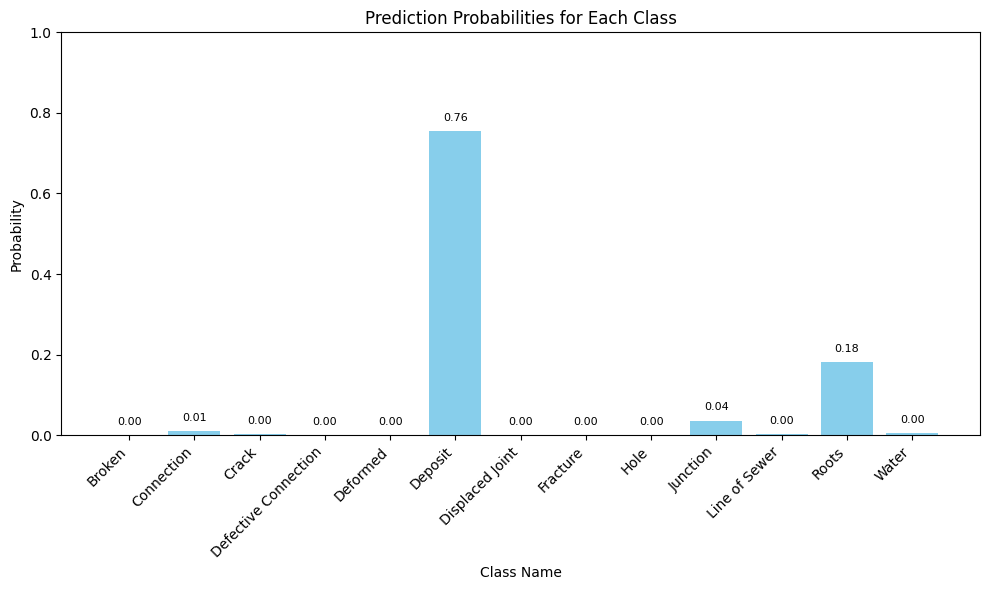

In [6]:
# --- Make the prediction ---
y_pred = model.predict(img_array)

# Convert logits to predicted class index
predicted_class_index = tf.argmax(y_pred, axis=1).numpy()[0]

# Define the class names
class_names = ['Broken', 'Connection', 'Crack', 'Defective Connection', 'Deformed', 'Deposit', 'Displaced Joint', 'Fracture', 'Hole', 'Junction', 'Line of Sewer', 'Roots', 'Water']

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

print(f"\n--- Prediction Result ---")
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")
print(f"True class name: {true_class_name}")

# --- Display Softmax Probabilities as a Bar Graph ---
# y_pred_logits is already a numpy array, so just take the first row
y_pred_probabilities = y_pred[0]

plt.figure(figsize=(10, 6))
plt.bar(class_names, y_pred_probabilities, color='skyblue')
plt.xlabel("Class Name")
plt.ylabel("Probability")
plt.title("Prediction Probabilities for Each Class")
plt.ylim(0, 1) # Probabilities are between 0 and 1

# Rotate x-axis labels if there are many classes for better readability
plt.xticks(rotation=45, ha="right")

# Add the probability values on top of the bars for clarity
for i, prob in enumerate(y_pred_probabilities):
    plt.text(i, prob + 0.02, f'{prob:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

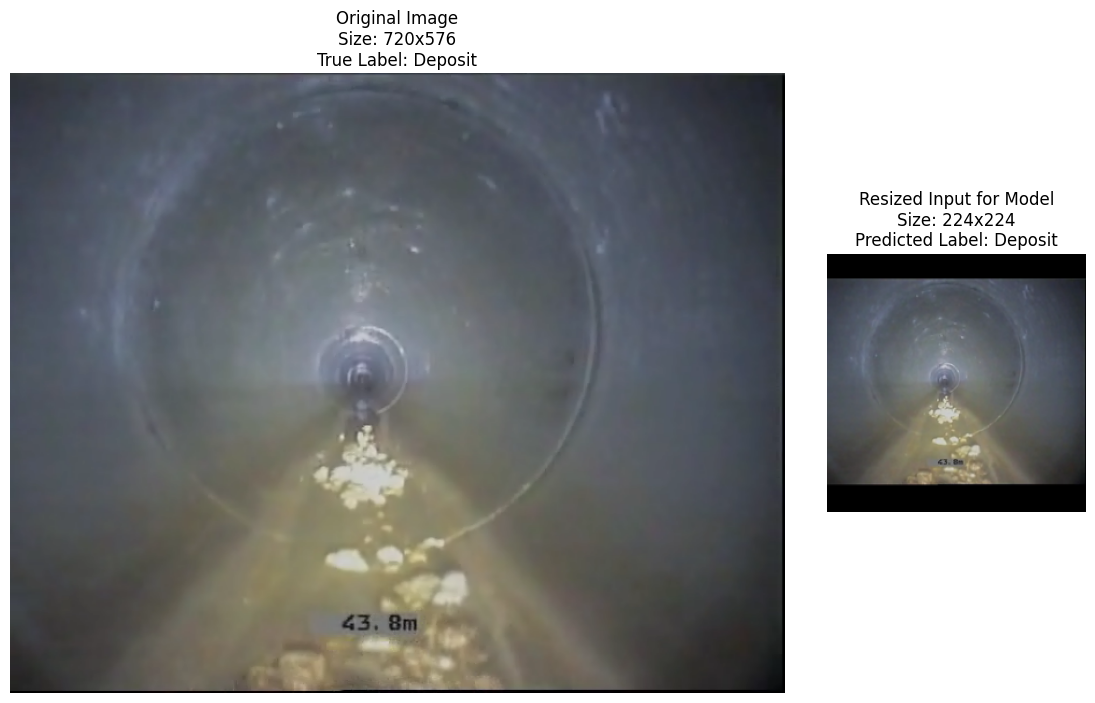

In [7]:
# --- Display the original and processed images with labels ---

# Calculate total width and max height for dynamic figure sizing
dpi = 100
total_width_px = original_img.size[0] + image_size[0] # Sum of widths of both images
max_height_px = max(original_img.size[1], image_size[1]) # Max height of either image

# Add some padding/margin to the figure size for better visual spacing
padding_factor = 1.2 # Adjust this factor as needed for more or less space
fig_width_inches = (total_width_px / dpi) * padding_factor
fig_height_inches = (max_height_px / dpi) * padding_factor

# Create a figure with dynamic size
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

# Use GridSpec to define subplot ratios based on image widths
gs = gridspec.GridSpec(1, 2, width_ratios=[original_img.size[0], image_size[0]])

# Plot Original Image
ax0 = fig.add_subplot(gs[0])
ax0.imshow(original_img)
ax0.set_title(f"Original Image\nSize: {original_img.size[0]}x{original_img.size[1]}\nTrue Label: {true_class_name}")
ax0.axis('off')

# Plot Resized/Padded Image
ax1 = fig.add_subplot(gs[1])
ax1.imshow(img) # This is the padded image
ax1.set_title(f"Resized Input for Model\nSize: {image_size[0]}x{image_size[1]}\nPredicted Label: {predicted_class_name}")
ax1.axis('off')

plt.tight_layout()
plt.show()